# Optimal 1D extraction

Here we will do a very basic optimal 1D extraction of the 2D spectrum. We will use routines amended from msaexp https://msaexp.readthedocs.io/en/latest/ for this purpose. 

Note there are many ways to do this, 
- for example you can also check out JDAT notebook here https://github.com/spacetelescope/jdat_notebooks/tree/main/notebooks/optimal_extraction 
- or use specviz https://jdaviz.readthedocs.io/en/latest/index.html following the notebook here https://github.com/spacetelescope/jdat_notebooks/blob/main/notebooks/mos_spectroscopy_advanced/MOSspec_advanced.ipynb

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import astropy
from astropy.io import ascii, fits
from jwst.datamodels import ImageModel

##### colours
tableau20 = [(31, 119, 180), (174, 199, 232), (255, 127, 14), (255, 187, 120),    
             (44, 160, 44), (152, 223, 138), (214, 39, 40), (255, 152, 150),    
             (148, 103, 189), (197, 176, 213), (140, 86, 75), (196, 156, 148),    
             (227, 119, 194), (247, 182, 210), (127, 127, 127), (199, 199, 199),    
             (188, 189, 34), (219, 219, 141), (23, 190, 207), (158, 218, 229)]    
  
# Scale the RGB values to the [0, 1] range, which is the format matplotlib accepts.    
for i in range(len(tableau20)):    
    r, g, b = tableau20[i]    
    tableau20[i] = (r / 255., g / 255., b / 255.) 
    
bluey = tableau20[0]
redy = tableau20[6]
lightredy = tableau20[7]
cyany = tableau20[18]
purpley = tableau20[8]
orangey = tableau20[2]
greeny = tableau20[4]
grey = tableau20[14]
pinky = tableau20[12]

col_array=[bluey, cyany, purpley, greeny, orangey, grey, pinky, redy]


## Couple of functions to make life easier

In [2]:
def make_msaexp_1d_extraction(stsci_spec_2d, bg_off = 5, prf_center=0, bkg_parity=[-1, 1], profile_slice=[1.0, 5.0], prf_sigma=2, fit_prf=True):    
    """
    extract a 1D from ST 2D using msaexp optimal extraction.
    """
    from msaexp.drizzle import make_optimal_extraction
    wcs = stsci_spec_2d.meta.wcs
    alpha_C, delta_C, yinfo = wcs(np.arange(0,stsci_spec_2d.shape[1]), np.zeros_like(stsci_spec_2d.shape[1]))
    wavelength = yinfo    
    ivar = 1.0/(stsci_spec_2d.err**2)
    ivar[np.isinf(ivar)]= 0

    sci2d, wht2d, profile2d, spec, prof_tab = make_optimal_extraction_tn(wavelength, stsci_spec_2d.data, ivar, profile_slice=profile_slice, center_limit=3,
                                                                      fit_prf=fit_prf, prf_center = prf_center , prf_sigma=prf_sigma, 
                                                                      bkg_offset=bg_off, bkg_parity=bkg_parity, max_wht_percentile=None, max_med_wht_factor=None, 
                                                                     offset_for_chi2= None)
    return sci2d, wht2d, profile2d, spec, prof_tab




def make_optimal_extraction_tn(waves, sci2d, wht2d, profile_slice=None, prf_center=None, prf_sigma=1.0, sigma_bounds=(0.5, 2.5), center_limit=4, fit_prf=True, fix_center=False, fix_sigma=False, trim=0, bkg_offset=6, bkg_parity=[-1,1], offset_for_chi2=1., max_wht_percentile=None, max_med_wht_factor=10, verbose=True, find_line_kws={}, ap_radius=None, ap_center=None, **kwargs):
    """
    Optimal extraction from 2D arrays--> Adapted from msaexp "make_optimal_extraction" function
                            
    Parameters
    ----------
    waves : 1D array
        Wavelengths, microns
    
    sci2d : 2D array
        Data array
    
    wht2d : 2D array
        Inverse variance weight array
    
    profile_slice : tuple, slice
        Slice along wavelength axis where to determine the cross-dispersion 
        profile.  If a tuple of floats, interpret as wavelength limits in 
        microns
    
    prf_center : float
        Profile center, relative to the cross-dispersion center of the array.  
        If `None`, then try to estimate it from the data
    
    prf_sigma : float
        Width of the extraction profile in pixels
    
    sigma_bounds : (float, float)
        Parameter bounds for `prf_sigma`
    
    center_limit : float
        Maximum offset from `prf_center` allowed
    
    fit_prf : bool
        Fit the profile.  If False, then just use the fixed values of 
        `prf_center` and `prf_sigma`
    
    fix_center : bool
        Fix the centering in the fit
    
    fix_sigma : bool
        Fix the width in the fit
    
    bkg_offset, bkg_parity : int, list
        Parameters for the local background determination (see 
        `~msaexp.drizzle.drizzle_slitlets`).  The profile is "subtracted" in the
        same way as the data.
    
    offset_for_chi2 : float
        If specified, compute chi2 of the profile fit offseting the first
        parameter by +/- this value
    
    max_wht_percentile : float
        Maximum percentile of WHT to consider valid
    
    max_med_wht_factor : float
        Maximum weight value relative to the median nonzero weight to consider valid
    
    ap_center, ap_radius : int, int
        Center and radius of fixed-width aperture extraction, in pixels.  If not
        specified, then
        
        .. code-block:: python
            :dedent:
        
            >>> ap_center = int(np.round(ytrace + fit_center))
            >>> ap_radius = np.clip(int(np.round(prof_sigma*2.35/2)), 1, 3)

    verbose : bool
        Status messages
    
    kwargs : dict
        Ignored keyword args
    
    Returns
    -------
    sci2d_out : array
        Output 2D sci array
    
    wht2d_out : array
        Output 2D wht array
    
    profile2d : array
        2D optimal extraction profile
    
    spec : `~astropy.table.Table`
        Optimally-extracted 1D spectrum
    
    prof_tab : `~astropy.table.Table`
        Table of the collapsed 1D profile
    """
    import scipy.ndimage as nd
    import astropy.units as u
    from scipy.optimize import least_squares
    
    import grizli
    from msaexp import utils
    
    # from .version import __version__ as msaexp_version
    
    sh = wht2d.shape
    yp, xp = np.indices(sh)
    
    ok = np.isfinite(sci2d*wht2d) & (wht2d > 0)
    if max_wht_percentile is not None:
        wperc = np.percentile(wht2d[ok], max_wht_percentile)
        # print('xxx max_wht_percentile', max_wht_percentile, ok.sum(), (ok & (wht2d < wperc)).sum(), wperc)
        ok &= wht2d < wperc
    
    if max_med_wht_factor is not None:
        med_wht = np.nanmedian(wht2d[ok])
        ok &= wht2d < max_med_wht_factor*med_wht
        
    wht_mask = wht2d*1
    wht_mask[~ok] = 0.
    
    if profile_slice is not None:
        if not isinstance(profile_slice, slice):
            if isinstance(profile_slice[0], int):
                # pixels
                profile_slice = slice(*profile_slice)
            else:
                # Wavelengths interpolated on pixel grid
                xpix = np.arange(sh[1])
                xsl = np.cast[int](np.round(np.interp(profile_slice,
                                                      waves,
                                                      xpix)))
                xsl = np.clip(xsl, 0, sh[1])
                print(f'Wavelength slice: {profile_slice} > {xsl} pix')
                profile_slice = slice(*xsl)
            
        prof1d = np.nansum((sci2d * wht_mask)[:,profile_slice], axis=1) 
        prof1d /= np.nansum(wht_mask[:,profile_slice], axis=1)
            
        slice_limits = profile_slice.start, profile_slice.stop
        
        pmask = ok & True
        pmask[:,profile_slice] &= True
        ok &= pmask
        
    else:
        prof1d = np.nansum(sci2d * wht_mask, axis=1) / np.nansum(wht_mask, axis=1)
        slice_limits = 0, sh[1]
    
    xpix = np.arange(sh[0])
    ytrace = (sh[0]-1)/2.
    x0 = np.arange(sh[0]) - ytrace
    y0 = yp - ytrace
        
    if prf_center is None:
        prf_center = np.nanargmax(prof1d) - (sh[0]-1)/2.
        
        if verbose:
            print(f'Set prf_center: {prf_center} {sh} {ok.sum()}')
    
    msg = f"msaexp.drizzle.extract_from_hdul: Initial center = "
    msg += f" {prf_center:6.2f}, sigma = {prf_sigma:6.2f}"
    grizli.utils.log_comment(grizli.utils.LOGFILE, msg, verbose=verbose, 
                             show_date=False)
    
    ############# 
    #### Integrated gaussian profile
    fit_type = 3 - 2*fix_center - 1*fix_sigma
    
    wht_mask[~ok] = 0.
    
    p00_name = None
    
    if fit_type == 0:
        args = (waves, sci2d, wht_mask, prf_center, prf_sigma,
                bkg_offset, bkg_parity, 3, 1, (verbose > 1))

        pnorm, pmodel = utils.objfun_prf([prf_center, prf_sigma], *args)
        profile2d = pmodel/pnorm
        pmask = (profile2d > 0) & np.isfinite(profile2d)
        profile2d[~pmask] = 0
        
        fit_center = prf_center
        fit_sigma = prf_sigma
        
    else:
        # Fit it
        if fix_sigma:
            p00_name = 'center'
            p0 = [prf_center]
            bounds = (-center_limit, center_limit)
        elif fix_center:
            p00_name = 'sigma'
            p0 = [prf_sigma]
            bounds = sigma_bounds
        else:
            p00_name = 'center'
            p0 = [prf_center, prf_sigma]
            bounds = ((-center_limit+prf_center, sigma_bounds[0]),
                      (center_limit+prf_center, sigma_bounds[1]))
            
        args = (waves, sci2d, np.ones_like(wht_mask), prf_center, prf_sigma,
                bkg_offset, bkg_parity, fit_type, 1, (verbose > 1))
        lmargs = (waves, sci2d, np.ones_like(wht_mask), prf_center, prf_sigma,
                  bkg_offset, bkg_parity, fit_type, 2, (verbose > 1))
        
        _res = least_squares(utils.objfun_prf, p0, args=lmargs, method='lm', loss='linear')
        
        # dchi2 / dp0
        if offset_for_chi2 is not None:
            chiargs = (waves, sci2d, wht_mask, prf_center, prf_sigma,
                       bkg_offset, bkg_parity, fit_type, 3, (verbose > 1))
            delta = _res.x*0.
            dchi2dp = []
            for d in [-offset_for_chi2, 0., offset_for_chi2]:
                delta[0] = d
                dchi2dp.append(utils.objfun_prf(_res.x+delta, *chiargs))
            
            msg = f"msaexp.drizzle.extract_from_hdul: dchi2/d{p00_name} = "
            dchi = (dchi2dp[0]-dchi2dp[1])
            dchi += (dchi2dp[2]-dchi2dp[1])
            msg += f'{dchi/2.:.1f}'
            grizli.utils.log_comment(grizli.utils.LOGFILE, msg, 
                                     verbose=verbose, 
                                     show_date=False)
            
        else:
            dchi2dp = None
            
        pnorm, pmodel = utils.objfun_prf(_res.x, *args)
        profile2d = pmodel/pnorm
        pmask = (profile2d > 0) & np.isfinite(profile2d)
        profile2d[~pmask] = 0
        
        if fix_sigma:
            fit_center = _res.x[0]
            fit_sigma = prf_sigma
        elif fix_center:
            fit_sigma = _res.x[0]
            fit_center = prf_center
        else:
            fit_center, fit_sigma = _res.x
    
    wht1d = np.nansum(wht_mask*profile2d**2, axis=0)
    sci1d = np.nansum(sci2d*wht_mask*profile2d, axis=0) / wht1d
    
    if profile_slice is not None:
        
        pfit1d = np.nansum((wht_mask*profile2d*sci1d)[:,profile_slice], axis=1) 
        pfit1d /= np.nansum((wht_mask)[:,profile_slice], axis=1)
    else:
        pfit1d = np.nansum(profile2d*sci1d*wht_mask, axis=1)
        pfit1d /= np.nansum(wht_mask, axis=1)
    
    if trim > 0:
        bad = nd.binary_dilation(wht1d <= 0, iterations=trim)
        wht1d[bad] = 0
        
    sci1d[wht1d <= 0] = 0
    err1d = np.sqrt(1/wht1d)
    err1d[wht1d <= 0] = 0
    
    ####### Make tables
    # Flux conversion
    # to_ujy = 1.e12*5.e-13 #drizzled_slits[0].meta.photometry.pixelarea_steradians
    to_ujy = 1.
    
    spec = grizli.utils.GTable()
    # spec.meta['VERSION'] = msaexp_version, 'msaexp software version'
        
    spec.meta['TOMUJY'] = to_ujy, 'Conversion from pixel values to microJansky'
    spec.meta['PROFCEN'] = fit_center, 'PRF profile center'
    spec.meta['PROFSIG'] = fit_sigma, 'PRF profile sigma'
    spec.meta['PROFSTRT'] = slice_limits[0], 'Start of profile slice'
    spec.meta['PROFSTOP'] = slice_limits[1], 'End of profile slice'
    spec.meta['YTRACE'] = ytrace, 'Expected center of trace'
    
    spec.meta['MAXWPERC'] = max_wht_percentile, 'Maximum weight percentile'
    spec.meta['MAXWFACT'] = max_med_wht_factor, 'Maximum weight factor'
    
    prof_tab = grizli.utils.GTable()
    # prof_tab.meta['VERSION'] = msaexp_version, 'msaexp software version'
    
    prof_tab['pix'] = x0
    prof_tab['profile'] = prof1d
    prof_tab['pfit'] = pfit1d
    prof_tab.meta['PROFCEN'] = fit_center, 'PRF profile center'
    prof_tab.meta['PROFSIG'] = fit_sigma, 'PRF profile sigma'
    prof_tab.meta['PROFSTRT'] = slice_limits[0], 'Start of profile slice'
    prof_tab.meta['PROFSTOP'] = slice_limits[1], 'End of profile slice'
    prof_tab.meta['YTRACE'] = ytrace, 'Expected center of trace'
    
    if (dchi2dp is not None) & (p00_name is not None):
        prof_tab.meta['DCHI2PAR'] = (p00_name,
                                     'Parameter for dchi2/dparam')
        prof_tab.meta['CHI2A'] = (dchi2dp[0],
                                  'Chi2 with d{p00_name} = -{offset_for_chi2}')
        prof_tab.meta['CHI2B'] = dchi2dp[1], 'Chi2 with dparam = 0. (best fit)'
        prof_tab.meta['CHI2C'] = (dchi2dp[2],
                                  'Chi2 with d{p00_name} = +{offset_for_chi2}')
        
    spec['wave'] = waves
    spec['wave'].unit = u.micron
    spec['flux'] = sci1d*to_ujy
    spec['err'] = err1d*to_ujy
    spec['flux'].unit = u.microJansky
    spec['err'].unit = u.microJansky
    
    # Aperture extraction
    if ap_center is None:
        ap_center = int(np.round(ytrace + fit_center))
    elif ap_center < 0:
        ap_center = np.nanargmax(prof1d)
        
    if ap_radius is None:
        ap_radius = np.clip(int(np.round(fit_sigma*2.35/2)), 1, 3)
    
    sly = slice(ap_center - ap_radius,
                ap_center + ap_radius+1)
                
    aper_sci = np.nansum(sci2d[sly,:], axis=0)
    aper_var = np.nansum(1./wht_mask[sly,:], axis=0)
    aper_corr = np.nansum(profile2d, axis=0) / np.nansum(profile2d[sly,:], axis=0)
    spec['aper_flux'] = aper_sci*to_ujy
    spec['aper_err'] = np.sqrt(aper_var)*to_ujy
    spec['aper_corr'] = aper_corr
    spec['aper_flux'].unit = u.microJansky
    spec['aper_err'].unit = u.microJansky
    
    spec['aper_flux'].description = f'Flux in trace aperture ({ap_center}, {ap_radius})'
    spec['aper_err'].description = ('Flux uncertainty in trace aperture '
                                    f'({ap_center}, {ap_radius})')
                                    
    spec.meta['APER_Y0'] = (ap_center, 'Fixed aperture center')
    spec.meta['APER_DY'] = (ap_radius, 'Fixed aperture radius, pix')
    
    msg = f"msaexp.drizzle.extract_from_hdul: aperture extraction = "
    msg += f"({ap_center}, {ap_radius})"
    grizli.utils.log_comment(grizli.utils.LOGFILE, msg, verbose=verbose, 
                             show_date=False)
    
    msk = np.isfinite(sci2d + wht_mask)
    sci2d[~msk] = 0
    wht_mask[~msk] = 0
    
    return sci2d*to_ujy, wht2d/to_ujy**2, profile2d, spec, prof_tab

In [3]:
def make_extraction_plot(sci2d, wht2d, spec_out, prof_tab, bg_off=5, comp_1d=None, save_fig=False, file_name=None):
    """
    make a basic image showing the 1d extraction profile and the 1d extraction. 
    """

    from astropy.visualization import  simple_norm

    fig, axs = plt.subplots(nrows=3, figsize=(10,8))
    axs = axs.flatten()
    
    ### flatten profile
    axs[0].plot(prof_tab['pix'], prof_tab['profile'] , color='k', ls='-', lw=3)
    axs[0].plot(prof_tab['pix'], prof_tab['pfit']    , color='k', ls='--', lw=3)
    
    axs[0].axvline(x=prof_tab[np.nanargmax(prof_tab['pfit'])]['pix'] + bg_off)
    axs[0].axvline(x=prof_tab[np.nanargmax(prof_tab['pfit'])]['pix'] - bg_off)


    axs[0].set_xlabel('spatial pixel number')

    axs[0].set_ylabel(r'flux sum in dispersion  [f$\nu$]')

    axs[0].legend()
    
    
    ### 2D spectrum
    power_norm = simple_norm(sci2d, 'power')
    axs[1].imshow(sci2d, norm=power_norm)
    

    #### 1D extraction
    ### work on f_mu space first
    spec_line = axs[2].errorbar(spec_out.wave, spec_out.fnu, yerr=spec_out.enu,  color=bluey, label='optimal extraction fmu')
    
    if comp_1d is not None:
        spec_line_comp = axs[2].errorbar(comp_1d['WAVELENGTH'], comp_1d['FLUX']*1e-6,  color='k', label='boxcar')
    
    
    axs[2].set_xlabel('Wavelength (microns)')
    axs[2].set_ylabel(r'$f_\nu [\mu Jy]$', color=bluey)
    

    axs[2].set_ylim(np.nanmedian(spec_out.query('1.0<wave<5.0').fnu) - (np.nanmedian(spec_out.query('1.0<wave<5.0').fnu)*2) , 
            np.nanmedian(spec_out.query('1.0<wave<5.0').fnu) + (np.nanmedian(spec_out.query('1.0<wave<5.0').fnu)*2)) 
    
    ### now do in f_lambda space
    ax2s = axs[2].twinx()
    spec_line = ax2s.errorbar(spec_out.wave, spec_out.flam, yerr=spec_out.elam,  color=greeny, label='optimal extraction flam')
    if comp_1d is not None:
        ### this allows one to compare with the box-car extraction performed by the ST pipeline. 
        ### You need to have that step run first and the file copied over for this to work. 
        spec_line_bc = ax2s.errorbar(comp_1d['WAVELENGTH'], comp_1d['FLAM'],  color='limegreen', label='boxcar extraction flam')
    
    ax2s.set_ylabel(r'$f_\lambda [erg/s/cm/\AA/\AA]$', color=greeny)

    
    ax2s.set_ylim(np.nanmedian(spec_out.query('1.0<wave<5.0').flam) - (np.nanmedian(spec_out.query('1.0<wave<5.0').flam)*2) , 
                np.nanmedian(spec_out.query('1.0<wave<5.0').flam) + (np.nanmedian(spec_out.query('1.0<wave<5.0').flam)*2)) 

    
    
    axs[2].legend(loc='upper right')
    ax2s.legend(loc='upper left')

    
    plt.tight_layout()
    

    if save_fig:
        plt.savefig(file_name.replace('_s2d.fits', '_o1d.pdf' ))
    
    return 

## Load 2D fits file (s2d image) and extract 1D spectrum

In [4]:
file_name = 'jw02565-o007_s20115_nirspec_clear-prism_s2d.fits'

In [5]:
stsci_spec_2d_sci = ImageModel(file_name)

### check the "make_optimal_extraction_tn" doctring to know what these params mean 
bg_off = 6
sci2d, wht2d, profile2d, spec, prof_tab  = make_msaexp_1d_extraction(stsci_spec_2d_sci, bg_off=bg_off, prf_center=3,  
                                                                     prf_sigma = 2, bkg_parity=[-1, 1], profile_slice=[2.0, 4.0], fit_prf=True)



Wavelength slice: [2.0, 4.0] > [113 260] pix
msaexp.drizzle.extract_from_hdul: Initial center =    3.00, sigma =   2.00
msaexp.drizzle.extract_from_hdul: aperture extraction = (27, 1)


/var/folders/r3/8rkwf3z12mgd39qrrfckpr3s0d32bj/T/ipykernel_56546/3832381813.py:9: RuntimeWarning: divide by zero encountered in divide
  ivar = 1.0/(stsci_spec_2d.err**2)
/var/folders/r3/8rkwf3z12mgd39qrrfckpr3s0d32bj/T/ipykernel_56546/3832381813.py:153: RuntimeWarning: invalid value encountered in divide
  prof1d /= np.nansum(wht_mask[:,profile_slice], axis=1)
/var/folders/r3/8rkwf3z12mgd39qrrfckpr3s0d32bj/T/ipykernel_56546/3832381813.py:260: RuntimeWarning: invalid value encountered in divide
  sci1d = np.nansum(sci2d*wht_mask*profile2d, axis=0) / wht1d
/var/folders/r3/8rkwf3z12mgd39qrrfckpr3s0d32bj/T/ipykernel_56546/3832381813.py:265: RuntimeWarning: invalid value encountered in divide
  pfit1d /= np.nansum((wht_mask)[:,profile_slice], axis=1)
/var/folders/r3/8rkwf3z12mgd39qrrfckpr3s0d32bj/T/ipykernel_56546/3832381813.py:275: RuntimeWarning: divide by zero encountered in divide
  err1d = np.sqrt(1/wht1d)
/var/folders/r3/8rkwf3z12mgd39qrrfckpr3s0d32bj/T/ipykernel_56546/3832381813.py:

2024-06-28 09:51:43,747 - stpipe - WARNING - No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


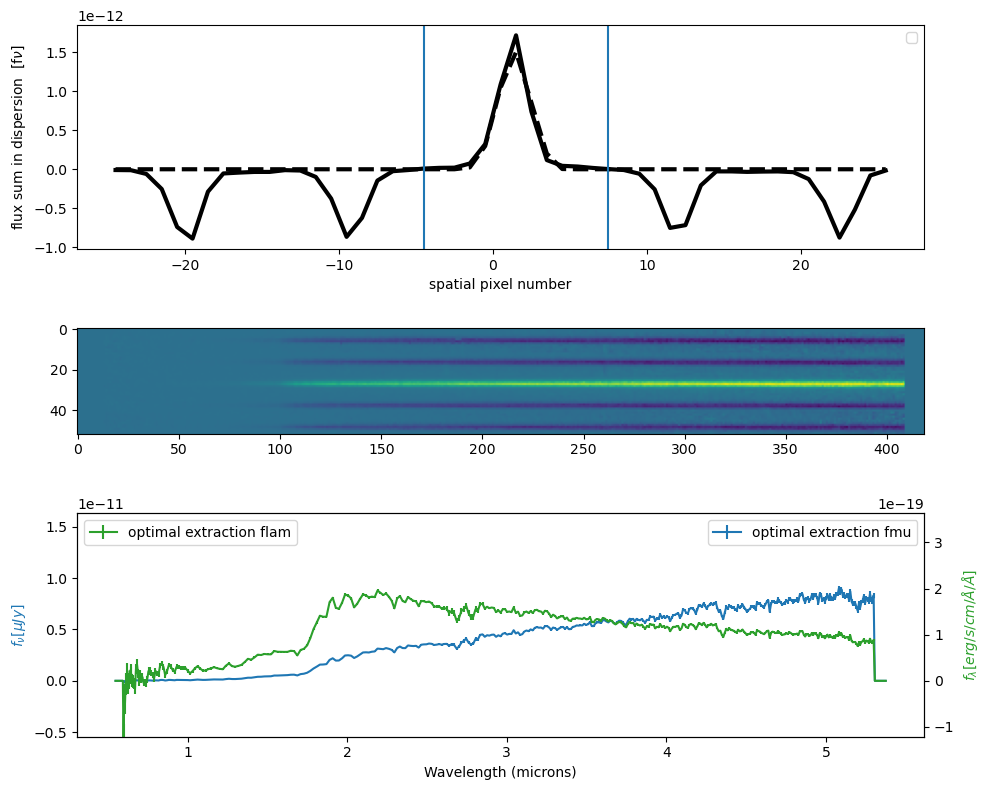

In [12]:
spec_out = pd.DataFrame(np.asarray(spec))
spec_out.rename({'flux':'fnu', 'err': 'enu'}, axis=1, inplace=True)
spec_out['flam'] = spec_out.fnu*1e6/3.34e4/((spec_out.wave*1e4)**2)
spec_out['elam'] = spec_out.enu*1e6/3.34e4/((spec_out.wave*1e4)**2)

make_extraction_plot(sci2d, np.ones_like(wht2d), spec_out, prof_tab, bg_off= bg_off, comp_1d=None, save_fig=True, file_name=file_name)


In [13]:
### save the extraction to a 1D file
spec_out.to_csv(file_name.replace('_s2d.fits', '_o1d.csv' ), index=False)